
# ------------------------Preprocess Workflow------------------------

After establishing a bounding box for the road sign, the image is cropped. In principle, this can result in bounding boxes with very different dimentions. Feeding these different-sized images into an image detection algorithm can be handled by various approaches, for example:
* Leave the images "as-is" and deal with _variable sized inputs_ into the image classification
* Re-size images 

In the context of this dataset, we decided that re-sizing images to a standard crop size would be one of the most acceptable approaches.  

It's important to note:
* Instead of simply filling-in with null data, target images are "stretched" to fit the standard crop (so as to not bias the detection with lots of empty data)
* This allows us to augment the dataset (add new entries to the dataset through deformations/transformations)

#### Requirements

In [1]:
import sys
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image
import skimage
from skimage.transform import rotate
from skimage.exposure import adjust_log
# from skimage.transform import rescale
import random
import keras
import scipy

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.



# -------------------Step 1: Explore Training Dataset-------------------


This dataset came with training examples of bounding boxes. For this exploration we'll:
1. Crop the training set images accordingly
2. Use the cropped images as our starting point

# Load label data

In [2]:
# load CSV with bounding boxes
train_df = pd.read_csv("../data/train.csv")
train_df.head()

,Img_Name,Top,Left,Width,Height,Label
0,02-25 13.26.44.jpg,131,1687,163,163,Speed Limit 80
1,02-25 13.33.43.jpg,399,256,36,33,Speed Limit 50
2,02-25 13.37.16.jpg,400,249,44,44,Speed Limit 50
3,02-25 14.21.59.jpg,392,458,34,32,Speed Limit 50
4,02-25 14.25.06.jpg,332,232,78,72,Speed Limit 50


# Explore image attributes
It's important to get a grasp of what the images look like, what to expect and how the features are distributed to know just how much transformation we can apply. We can also do some quality checks (like seeing how imbalanced the classes are) and some visualization of the data.

### Classes

Counts of each sign type:
 Speed Limit 50    120
Speed Limit 40    110
Speed Limit 30     80
Speed Limit 20     65
Speed Limit 80     49
Speed Limit 60     44
Name: Label, dtype: int64


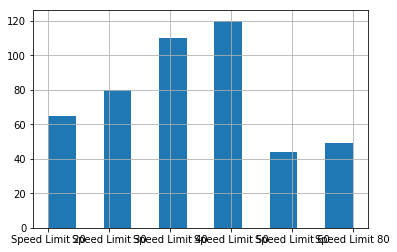

In [3]:
# distribution of classes
print("Counts of each sign type:\n",train_df['Label'].value_counts())
train_df["Label"].hist(bins=11)

* The most numerous sign types are the 40km/hr and 50km/hr
* The least numerous sign types are 60km/hr and 80km/hr
* There are roughly **3 times** more *40's and 50's* than *60's and 80's*

### Bounding Boxes

In [4]:
# max width of a bounding box
print ("width  by height")
print (train_df['Width'].max(),"px by",train_df['Height'].max(),"px")

width  by height
191 px by 244 px


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1336cebe0>,
      dtype=object)

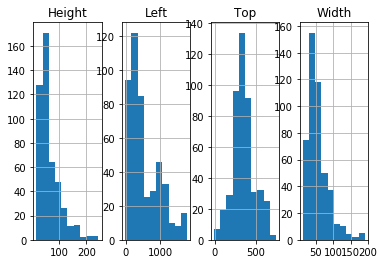

In [5]:
# distribution of values
train_df.hist(layout=(1,4))

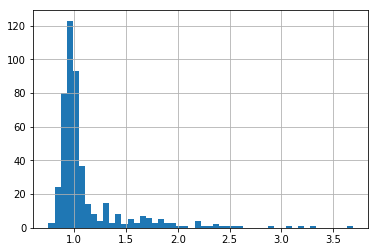

In [6]:
# height/width ratio
train_df["HWratio"] = round(train_df["Height"]/train_df["Width"],2)
train_df["HWratio"].hist(bins=50)


* Height/Width ratio = 1 means a **square box**
* Height/Width ratio > 1 means a _taller_ image
* Height/Width ratio < 1 means a _fatter_ image

Most of the images in the training dataset are square-ish; the outliers at the extremes seem to be skewed by almost 4x (four times as tall than they are wide).

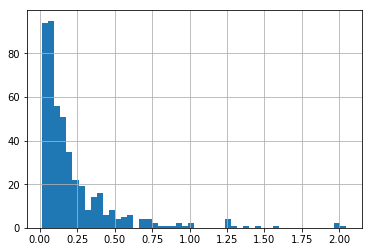

In [7]:
# crop ratio (percent of original image used)
train_df["%_image_used"] = 100*(train_df["Width"]*train_df["Height"])/(1080*1920)
train_df["%_image_used"].hist(bins=50)

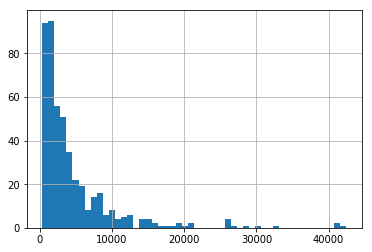

In [8]:
# size of cropped image
train_df["crop_total_pixels"] = train_df["Width"]*train_df["Height"]
train_df["crop_total_pixels"].hist(bins=50)

The vast majority of the cropped images are rather small (< 5,000pixels). That is, most of the cropped images are smaller than **250px by 250px**

# --------------------Step 2: Initial Crop ---------------------

# Check cropping

Filename:  02-25 16.15.24.jpg
Bounding Box: (Top,Left,Width,Height) 273 1424 82 199
Image Dimensions:  (1920, 1080)


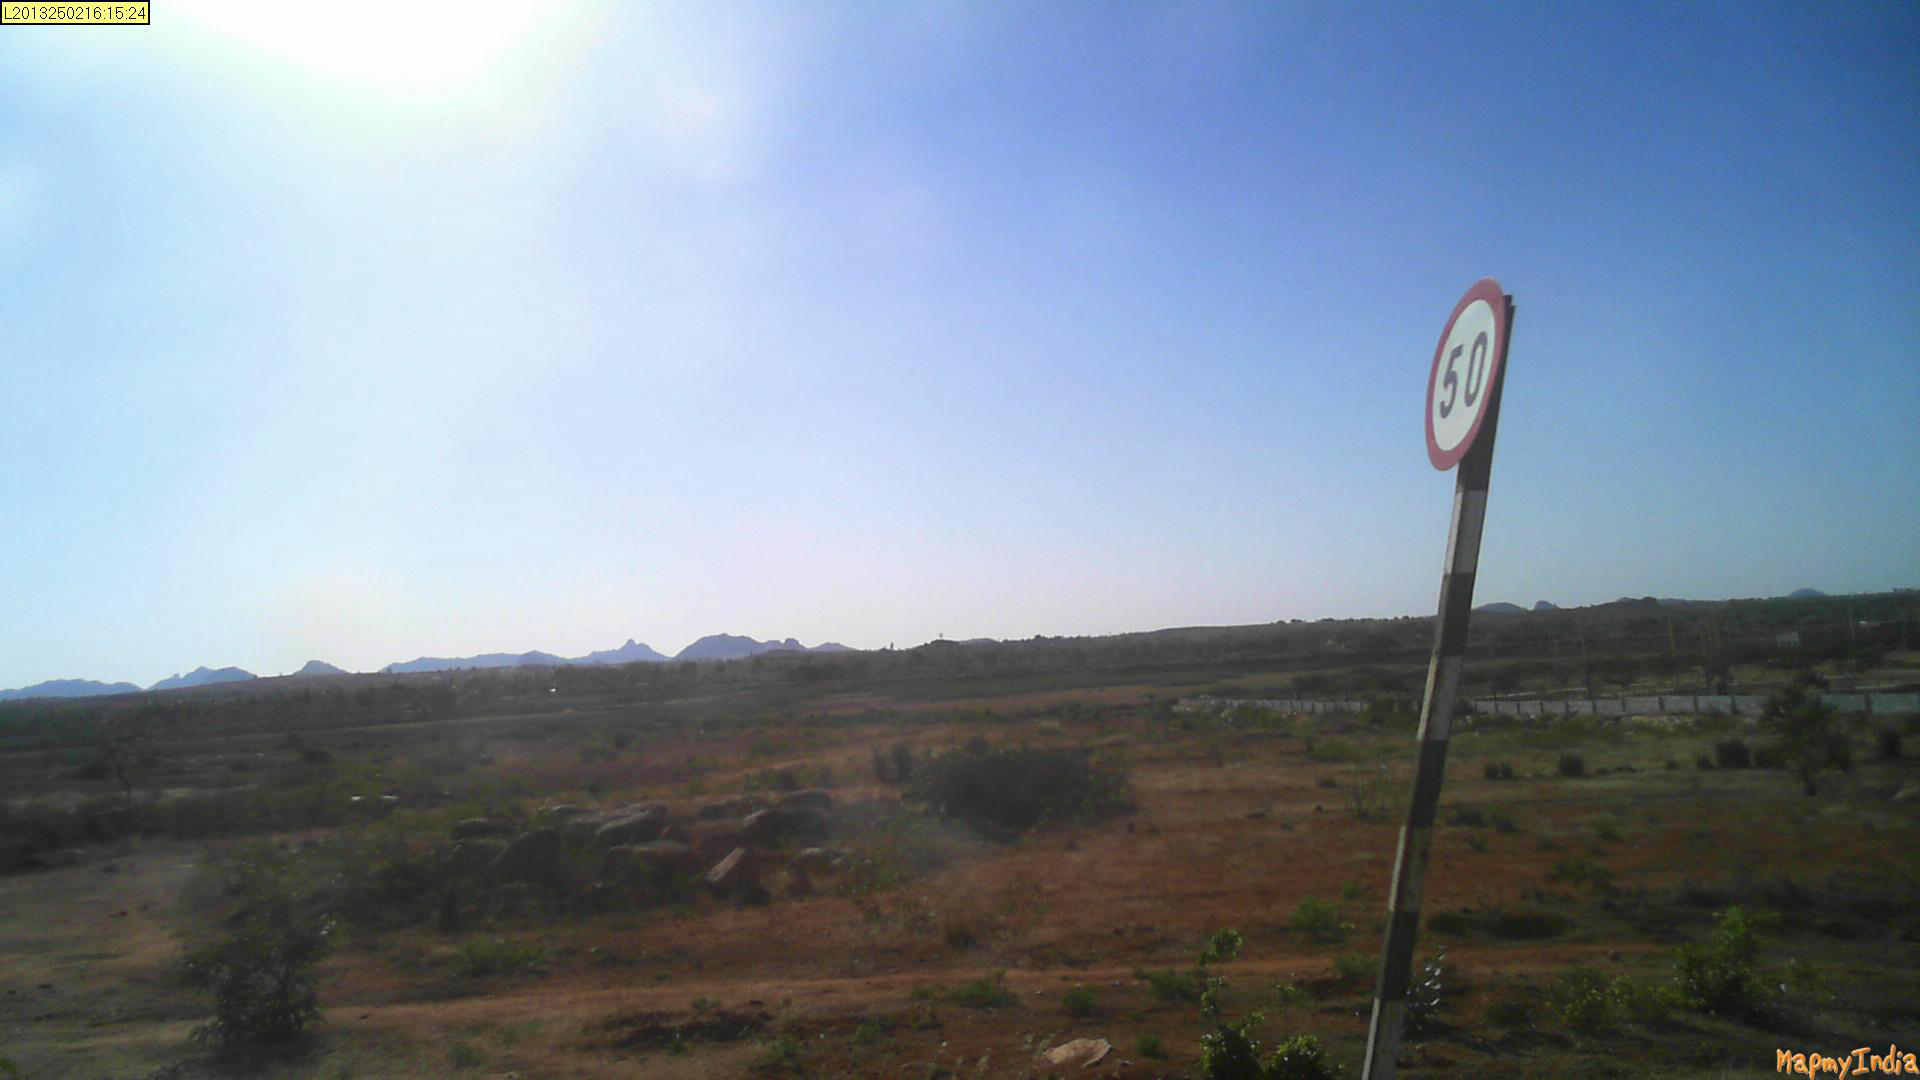

Bounding Pixels:  (1424, 273, 1506, 472)


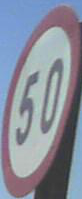

In [9]:
# crop example image to verify working
for index,row in train_df[19:20].iterrows():
    
    # open file
    file = row.Img_Name
    image = Image.open("../data/train/%s" % file, 'r')
    
    # display image
    print ("Filename: ", file)
    print ("Bounding Box: (Top,Left,Width,Height)", row.Top, row.Left, row.Width, row.Height)
    print ("Image Dimensions: ", image.size)
    display(image)
    
    # crop 
    right = (row.Left + row.Width)
    lower = (row.Top + row.Height)
    box = (row.Left, row.Top, right, lower)
    
    # display cropped
    print ("Bounding Pixels: ", box)
    image_crop = image.crop(box)
    display(image_crop)

Bounding Pixels:  (304, 382, 351, 428)


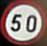

Bounding Pixels:  (191, 355, 237, 410)


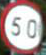

Bounding Pixels:  (97, 331, 166, 404)


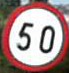

Bounding Pixels:  (289, 374, 339, 423)


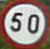

Bounding Pixels:  (560, 444, 581, 467)


In [10]:
# print some example crops
for index,row in train_df[10:15].iterrows():
    file = row.Img_Name
    image = Image.open("../data/train/%s" % file, 'r')
    
    # crop 
    width, height = image.size
    right = (row.Left + row.Width)
    lower = (row.Top + row.Height)
    box = (row.Left, row.Top, right, lower)
    image_crop = image.crop(box)
    
    # display
    print ("Bounding Pixels: ", box)
    display(image_crop)

Visualization of the crops confirms what we saw in the histagrams above, namely that some of the resultant images are _quite small_

# Standardize cropped images

We'll walk-through this process here and then build functional scripts at the end of the explorations which we can use to iterate over the dataset and apply all at once.

We know that the max width and height are **191 px by 244 px**. In order to simplify the following actions, we can define the standard input for image classification to be **250px by 250px**.

===========================================Original Crop============================================


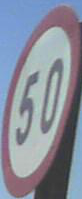

Previous Shape:  (199, 82, 3)
=========================================Forced to 250x250==========================================


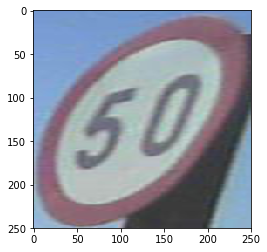

New Shape:  (250, 250, 3)


In [11]:
for index,row in train_df[19:20].iterrows():
    
    # open file
    file = row.Img_Name
    image = Image.open("../data/train/%s" % file, 'r')
    
    # crop 
    width, height = image.size
    right = (row.Left + row.Width)
    lower = (row.Top + row.Height)
    box = (row.Left, row.Top, right, lower)
    
    # display cropped
    print('{:=^100}'.format('Original Crop'))
    image_crop = image.crop(box)
    display(image_crop)
    image_crop = np.array(image_crop)                                                # needs to by numpy array for transform
    print ("Previous Shape: ", image_crop.shape)
    
    # transform 
    image_crop = np.array(image_crop)                                                 
    image_trans = cv2.resize(image_crop,(250, 250), interpolation = cv2.INTER_CUBIC)
    h,w = image_trans.shape[:2]
    
    # display transformed
    print('{:=^100}'.format('Forced to 250x250'))
    plt.imshow(image_trans)
    plt.show()
    print("New Shape: ", image_trans.shape)

Note that forcing the shape to 250x250 is an inadvertant stretch to begin with, one which is out of our control. However, since we'll be applying random transformations to augment the dataset, we're not concerned with this detail.

# ------------------Step 3: Tranformations -------------------

In order to augment the dataset by generating new images from the small set we have to begin with, we can perform various transformations on the original crop. The degree to which each is applied (how "strong" each effect is) can be randomized so that each time we perform a tranformation we end up with an entirely new image to be used for training our classification system. These include:  

* sheer _(beyond that which is present in the 250x250 "stretch")_
* ~~flip~~ 
* grayscale     
* gamma correction
* rotation (+/- 45 degrees)
* zoom
* shift
* blur
  * various types
  * apply random rescaling (+/- 20%)



Flipping will not work because numbers will be mirror-images.

It's worth commenting that grayscale is often used for image classification as it reduces the computational needs (one channel instead of three) and that literature suggests that leaving the images in color may only be of limited benefit.



# Step-by-step walkthrough

So far, we've used **cv2** (a computer vision library) and **Pillow** (Python's Image Library, PIL) to handle some of our basic image manipulations. For this section, we will draw on **Scikit Learn Image**, **SciPy** and **Keras** libraries to help apply these transformations

#### First, let's define some functions

In [12]:
def transform_matrix_offset_center(matrix, x, y):
    """
    Used in apply_affine_transform()
    """
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

In [13]:
def apply_affine_transform(x, theta=0, tx=0, ty=0, shear=0, zx=1, zy=1,
                           row_axis=0, col_axis=1, channel_axis=2,
                           fill_mode='nearest', cval=0., order=1):
    
    """
    Applies an affine transformation specified by the parameters given.
    
    # Arguments
        x: 2D numpy array, single image.
        theta: Rotation angle in degrees.
        tx: Width shift.
        ty: Heigh shift.
        shear: Shear angle in degrees.
        zx: Zoom in x direction.
        zy: Zoom in y direction
        row_axis: Index of axis for rows in the input image.
        col_axis: Index of axis for columns in the input image.
        channel_axis: Index of axis for channels in the input image.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
        order int: order of interpolation
        
    # Returns
        The transformed version of the input.
        
    """
    
    if scipy is None:
        raise ImportError('Image transformations require SciPy. '
                          'Install SciPy.')
    transform_matrix = None
    if theta != 0:
        theta = np.deg2rad(theta)
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                    [np.sin(theta), np.cos(theta), 0],
                                    [0, 0, 1]])
        transform_matrix = rotation_matrix

    if tx != 0 or ty != 0:
        shift_matrix = np.array([[1, 0, tx],
                                 [0, 1, ty],
                                 [0, 0, 1]])
        if transform_matrix is None:
            transform_matrix = shift_matrix
        else:
            transform_matrix = np.dot(transform_matrix, shift_matrix)

    if shear != 0:
        shear = np.deg2rad(shear)
        shear_matrix = np.array([[1, -np.sin(shear), 0],
                                 [0, np.cos(shear), 0],
                                 [0, 0, 1]])
        if transform_matrix is None:
            transform_matrix = shear_matrix
        else:
            transform_matrix = np.dot(transform_matrix, shear_matrix)

    if zx != 1 or zy != 1:
        zoom_matrix = np.array([[zx, 0, 0],
                                [0, zy, 0],
                                [0, 0, 1]])
        if transform_matrix is None:
            transform_matrix = zoom_matrix
        else:
            transform_matrix = np.dot(transform_matrix, zoom_matrix)

    if transform_matrix is not None:
        h, w = x.shape[row_axis], x.shape[col_axis]
        transform_matrix = transform_matrix_offset_center(
            transform_matrix, h, w)
        x = np.rollaxis(x, channel_axis, 0)
        final_affine_matrix = transform_matrix[:2, :2]
        final_offset = transform_matrix[:2, 2]

        channel_images = [scipy.ndimage.interpolation.affine_transform(
            x_channel,
            final_affine_matrix,
            final_offset,
            order=order,
            mode=fill_mode,
            cval=cval) for x_channel in x]
        x = np.stack(channel_images, axis=0)
        x = np.rollaxis(x, 0, channel_axis + 1)
    return x

In [14]:
def random_shift(x, wrg, hrg, row_axis=1, col_axis=2, channel_axis=0,
                 fill_mode='nearest', cval=0., interpolation_order=1):
    
    """
    Performs a random spatial shift of a Numpy image tensor.
    
    # Arguments
        x: Input tensor. Must be 3D.
        wrg: Width shift range, as a float fraction of the width.
        hrg: Height shift range, as a float fraction of the height.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
        interpolation_order int: order of spline interpolation.
            see `ndimage.interpolation.affine_transform`
    
    # Returns
        Shifted Numpy image tensor.
    
    """
    
    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = np.random.uniform(-hrg, hrg) * h
    ty = np.random.uniform(-wrg, wrg) * w
    x = apply_affine_transform(x, tx=tx, ty=ty, channel_axis=channel_axis,
                               fill_mode=fill_mode, cval=cval,
                               order=interpolation_order)
    return x

In [15]:
def random_zoom(x, zoom_range, row_axis=1, col_axis=2, channel_axis=0,
                fill_mode='nearest', cval=0., interpolation_order=1):
    
    """
    Performs a random spatial zoom of a Numpy image tensor.
    
    # Arguments
        x: Input tensor. Must be 3D.
        zoom_range: Tuple of floats; zoom range for width and height.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
        interpolation_order int: order of spline interpolation.
            see `ndimage.interpolation.affine_transform`
            
    # Returns
        Zoomed Numpy image tensor.
        
    # Raises
        ValueError: if `zoom_range` isn't a tuple.
        
    """
    
    if len(zoom_range) != 2:
        raise ValueError('`zoom_range` should be a tuple or list of two'
                         ' floats. Received: %s' % (zoom_range,))

    if zoom_range[0] == 1 and zoom_range[1] == 1:
        zx, zy = 1, 1
    else:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
    x = apply_affine_transform(x, zx=zx, zy=zy, channel_axis=channel_axis,
                               fill_mode=fill_mode, cval=cval,
                               order=interpolation_order)
    return x

In [16]:
def random_shear(x, intensity, row_axis=1, col_axis=2, channel_axis=0,
                 fill_mode='nearest', cval=0., interpolation_order=1):
    
    """
    Performs a random spatial shear of a Numpy image tensor.
    
    # Arguments
        x: Input tensor. Must be 3D.
        intensity: Transformation intensity in degrees.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
        interpolation_order int: order of spline interpolation.
            see `ndimage.interpolation.affine_transform`
    
    # Returns
        Sheared Numpy image tensor.
        
    """
    
    shear = np.random.uniform(-intensity, intensity)
    x = apply_affine_transform(x, shear=shear, channel_axis=channel_axis,
                               fill_mode=fill_mode, cval=cval,
                               order=interpolation_order)
    return x


#### Now, let's step through some transformations

====================================================================Original Crop=====================================================================


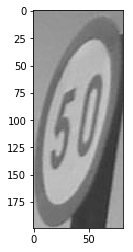

============================================================Original Crop -> Force 250x250============================================================


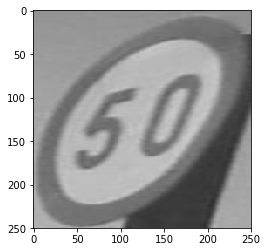

=======================================================Original Crop -> Force 250x250 -> Rotate=======================================================


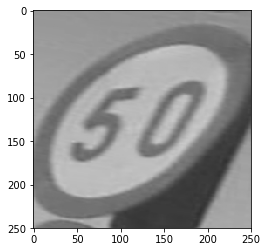

===================================================Original Crop -> Force 250x250 -> Rotate -> Blur===================================================


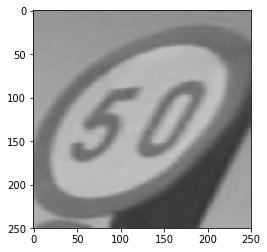

==============================================Original Crop -> Force 250x250 -> Rotate -> Blur -> Gamma===============================================


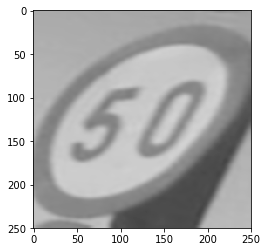

=========================================Original Crop -> Force 250x250 -> Rotate -> Blur -> Gamma -> Rescale=========================================
rescale


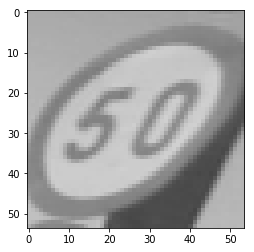

rescale interpolated


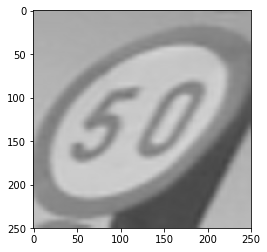

====================================Original Crop -> Force 250x250 -> Rotate -> Blur -> Gamma -> Rescale -> Shift=====================================


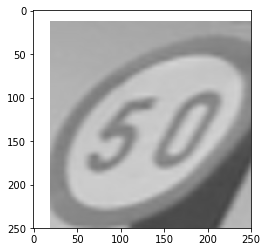

================================Original Crop -> Force 250x250 -> Rotate -> Blur -> Gamma -> Rescale -> Shift -> Zoom=================================


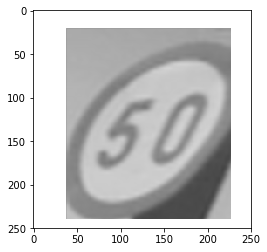

========================Original Crop -> Force 250x250 -> Rotate -> Blur -> Gamma -> Rescale -> Shift -> Zoom -> Restandardize========================


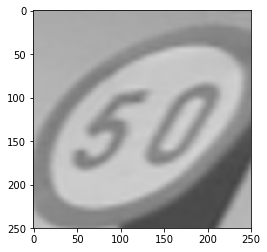

===================Original Crop -> Force 250x250 -> Rotate -> Blur -> Gamma -> Rescale -> Shift -> Zoom -> Restandardize -> Shear====================


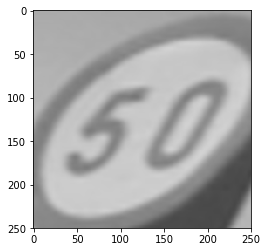

CPU times: user 1.58 s, sys: 62.7 ms, total: 1.64 s
Wall time: 1.63 s


In [17]:
%%time
for index,row in train_df[19:20].iterrows():
    
    # open file
    file = row.Img_Name
    image = Image.open("../data/train/%s" % file, 'r').convert('LA')     # force grayscale on load
    
    ###########      crop      ###########
    print('{:=^150}'.format('Original Crop'))
    width, height = image.size
    right = (row.Left + row.Width)
    lower = (row.Top + row.Height)
    box = (row.Left, row.Top, right, lower)
    image_crop = image.crop(box)
    
    # display
    plt.imshow(image_crop)
    plt.show()
    
    ########### force to 250x250 ###########
    print('{:=^150}'.format('Original Crop -> Force 250x250'))
    image_crop = np.array(image_crop)                                    # needs to by numpy array for transform                              
    image_trans = cv2.resize(image_crop,(250, 250))
    image_trans = Image.fromarray(image_trans)                           # convert back into PIL object
    
    # display
    plt.imshow(image_trans)
    plt.show()
    
    ########### rotate ###########
    print('{:=^150}'.format('Original Crop -> Force 250x250 -> Rotate'))
    image_trans = np.array(image_trans)                                   # needs to by numpy array for transform     
    image_rotate = skimage.transform.rotate(image_trans, random.uniform(-30, 30),resize=False, mode="symmetric")
    image_rotate = Image.fromarray(np.uint8(image_rotate*255))            # convert back into PIL object
    
    # display
    plt.imshow(image_rotate)
    plt.show()
    
    ########### blur1 ###########
    print('{:=^150}'.format('Original Crop -> Force 250x250 -> Rotate -> Blur'))
    image_rotate = np.array(image_rotate)                                  # needs to by numpy array for transform 
    kernel = np.ones((5,5),np.float32)/25                                  # set up for use in the blur
    image_blur = cv2.filter2D(image_rotate,-1,kernel)
    image_blur = Image.fromarray(image_blur)                               # convert back into PIL object

    # display
    plt.imshow(image_blur)
    plt.show()
    
    ########### gamma ###########
    print('{:=^150}'.format('Original Crop -> Force 250x250 -> Rotate -> Blur -> Gamma'))
    image_blur = np.array(image_blur)                                      # needs to by numpy array for transform 
    image_gamma = skimage.exposure.adjust_log(image_blur)
    image_gamma = Image.fromarray(image_gamma)                             # convert back into PIL object

    # display
    plt.imshow(image_gamma)
    plt.show()
    
    ########### rescale ###########
    print('{:=^150}'.format('Original Crop -> Force 250x250 -> Rotate -> Blur -> Gamma -> Rescale'))
    image_gamma = np.array(image_gamma)                                     # needs to by numpy array for transform 
    image_rescale = skimage.transform.rescale(image_gamma, random.uniform(.2,.3), mode='constant')
    image_rescaleC = cv2.resize(image_rescale,(250, 250), interpolation = cv2.INTER_CUBIC)
    image_rescaleC = Image.fromarray(np.uint8(image_rescaleC*255))          # convert back into PIL object

    # display
    print('rescale')
    plt.imshow(Image.fromarray(np.uint8(image_rescale*255)))
    plt.show()
    print('rescale interpolated')
    plt.imshow(image_rescaleC)
    plt.show()    
    
    ########### shift ###########
    print('{:=^150}'.format('Original Crop -> Force 250x250 -> Rotate -> Blur -> Gamma -> Rescale -> Shift'))
    image_rescaleC = np.array(image_rescaleC)                                # needs to by numpy array for transform
    image_shift = random_shift(image_rescaleC, wrg=0.1, hrg=0.2, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0)
    image_shift = Image.fromarray(image_shift)                               # convert back into PIL object 
    
    # display
    plt.imshow(image_shift)
    plt.show()    

    ########### zoom ###########
    print('{:=^150}'.format('Original Crop -> Force 250x250 -> Rotate -> Blur -> Gamma -> Rescale -> Shift -> Zoom'))
    image_shift = np.array(image_shift)                                      # needs to by numpy array for transform
    image_zoom = random_zoom(image_shift, zoom_range=(1.05,1.25), row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0)
    image_zoom = Image.fromarray(image_zoom)                                 # convert back into PIL object
    
    # display
    plt.imshow(image_zoom)
    plt.show()    

    ########### restandardize ###########
    print('{:=^150}'.format('Original Crop -> Force 250x250 -> Rotate -> Blur -> Gamma -> Rescale -> Shift -> Zoom -> Restandardize'))
    image_restandard = np.array(image_zoom)                                  # needs to by numpy array for transform
    h,w,d = image_restandard.shape
    for i in range(w):                                                       #left limit
        if np.sum(image_restandard[:,i-1,:]) > 0:
            break
    for j in range(w-1,0,-1):                                                #right limit      
        if np.sum(image_restandard[:,j-1,:]) > 0:
            break
    for k in range(h):                                                       #upper limit
        if np.sum(image_restandard[k-1,:,:]) > 0:
            break
    for l in range(h-1,0,-1):                                                #lower limit
        if np.sum(image_restandard[l-1,:,:]) > 0:
            break
    image_restandard = image_restandard[k:l:,i:j,:].copy()                   # deep copy to get byte-aligned array needed for opencv
    image_restandard = cv2.resize(image_restandard,(250, 250))
    image_restandard = Image.fromarray(image_restandard)                     # convert back into PIL object
    
    # display
    plt.imshow(image_restandard)
    plt.show() 
    
    
    ########### shear ###########
    print('{:=^150}'.format('Original Crop -> Force 250x250 -> Rotate -> Blur -> Gamma -> Rescale -> Shift -> Zoom -> Restandardize -> Shear'))
    image_new = np.array(image_restandard)                                   # needs to by numpy array for transform
    image_new = random_shear(image_new, intensity=1, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0)
    image_new = random_zoom(image_new, zoom_range=(0.9,0.95), row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0)
    image_new = Image.fromarray(image_new)                                   # convert back into PIL object
    
    # display
    plt.imshow(image_new)
    plt.show() 
    

# -------------Step 4: Build Augmented Dataset --------------

Now that we know how each step will be performed and what the result will be at each iteration, we can re-write the the entire transformation as a function that can be applied to any image, and add a wrapper to load/save.

In [153]:
def transform(source_path, filename, dest_path, data, original=True):
    """
    
    Takes a file, saves the original crop and then one random transformation.
    Random transformations are saved with a random number appended to the filename.
    
    e.g. source_path = '../data/train/' (of an original, full-sized image) 
    e.g. filename    = 'filename.jpg'
    e.g. dest_path   = '../data/train/augmented/'
    e.g. iterations  = 25 (should be =< 99)
    
    Saves original crop in grayscale as filename_0000.jpg in dest_path
    Saves randomly transformed images as filename_####.jpg in dest_path
    
    'original' flag takes boolean.
        If True, saves only original crop.
        If False, saves only transformation.
    
    """
    # check desination folder create, if not then create
    if os.path.isdir(dest_path) == False:
        os.makedirs(dest_path)
    else:
        pass
    
    # load image
    re_path = source_path+"%s"
    image = Image.open(re_path % filename, 'r').convert('LA')           # PIL object, force grayscale on load

    # crop
    this  =  data[data['Img_Name']==filename]
    left  =          this.Left.values[0]
    top   =          this.Top.values[0]
    right = (left +  this.Width.values[0] )
    lower = (top  +  this.Height.values[0])
#     left, top, right, lower = np.vectorize(np.int64(left)),np.vectorize(np.int64(top)),np.vectorize(np.int64(right)),np.vectorize(np.int64(lower))
#     left, top, right, lower = int(left[0]), int(top[0]), int(right[0]), int(lower[0])
    box   = (left, top, right, lower)
    image_crop = image.crop(box)
        
    # force to 250x250
    image_crop = np.array(image_crop)                                    # needs to by numpy array for transform                              
    image_trans = cv2.resize(image_crop,(250, 250))
    image_trans = Image.fromarray(image_trans)                           # convert back into PIL object

    ## flag 'original'
    if original == True: 
        image_trans.convert('RGB').save(dest_path+"%s_0000.jpg" % filename[:-4])
        return
    else:
        pass
    
    # rotate
    image_trans = np.array(image_trans)                                   # needs to by numpy array for transform     
    image_rotate = skimage.transform.rotate(image_trans, random.uniform(-30, 30),resize=False, mode="symmetric")
    image_rotate = Image.fromarray(np.uint8(image_rotate*255))            # convert back into PIL object
    
    # blur
    image_rotate = np.array(image_rotate)                                  # needs to by numpy array for transform 
    kernel = np.ones((5,5),np.float32)/25                                  # set up for use in the blur
    image_blur = cv2.filter2D(image_rotate,-1,kernel)
    image_blur = Image.fromarray(image_blur)                               # convert back into PIL object

    # gamma correction
    image_blur = np.array(image_blur)                                      # needs to by numpy array for transform 
    image_gamma = skimage.exposure.adjust_log(image_blur)
    image_gamma = Image.fromarray(image_gamma)                             # convert back into PIL object

    # rescale
    image_gamma = np.array(image_gamma)                                     # needs to by numpy array for transform 
    image_rescale = skimage.transform.rescale(image_gamma, random.uniform(.2,.3), mode='constant')
    image_rescaleC = cv2.resize(image_rescale,(250, 250), interpolation = cv2.INTER_CUBIC)
    image_rescaleC = Image.fromarray(np.uint8(image_rescaleC*255))          # convert back into PIL object

    # shift
    image_rescaleC = np.array(image_rescaleC)                                # needs to by numpy array for transform
    image_shift = random_shift(image_rescaleC, wrg=0.1, hrg=0.2, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0)
    image_shift = Image.fromarray(image_shift)                               # convert back into PIL object 
    
    # zoom
    image_shift = np.array(image_shift)                                      # needs to by numpy array for transform
    image_zoom = random_zoom(image_shift, zoom_range=(1.05,1.25), row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0)
    image_zoom = Image.fromarray(image_zoom)                                 # convert back into PIL object  

    # restandardize
    image_restandard = np.array(image_zoom)                                  # needs to by numpy array for transform
    h,w,d = image_restandard.shape
    for i in range(w):                                                       #left limit
        if np.sum(image_restandard[:,i-1,:]) > 0:
            break
    for j in range(w-1,0,-1):                                                #right limit      
        if np.sum(image_restandard[:,j-1,:]) > 0:
            break
    for k in range(h):                                                       #upper limit
        if np.sum(image_restandard[k-1,:,:]) > 0:
            break
    for l in range(h-1,0,-1):                                                #lower limit
        if np.sum(image_restandard[l-1,:,:]) > 0:
            break
    image_restandard = image_restandard[k:l:,i:j,:].copy()                   # deep copy to get byte-aligned array needed for opencv
    image_restandard = cv2.resize(image_restandard,(250, 250))
    image_restandard = Image.fromarray(image_restandard)                     # convert back into PIL object

    # shear
    image_new = np.array(image_restandard)                                   # needs to by numpy array for transform
    image_new = random_shear(image_new, intensity=1, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0)
    image_new = random_zoom(image_new, zoom_range=(0.9,0.95), row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0)
    image_new = Image.fromarray(image_new)                                   # convert back into PIL object
    
    # save filename_####.jpg
    dest_num = str(np.random.randint(low=1000,high=9999,size=1)[0])
    re_dest = dest_path+'%s_'+dest_num+".jpg"
    image_new.convert('RGB').save(re_dest % filename[:-4])    
    

#### And now, magic happens

In [155]:
%%time
source_path = '../data/train/'
dest_path   = '../data/train/augmented/'

# save original crop for each line in dataset
for index,row in train_df.iterrows():
    transform (source_path, row.Img_Name, dest_path, data=train_df, original=True)

# save original crop for each line in dataset
for i in range(25):
    for index,row in train_df.iterrows():
        transform (source_path, row.Img_Name, dest_path, data=train_df, original=False)


CPU times: user 16min 48s, sys: 27.2 s, total: 17min 15s
Wall time: 17min 38s


Now we have 
* 1 of each original crop
* 25 random transformations of that crop

We started with **468** images for training, and now we have **12,151**  
We won't balance any of the classes, as it's likely that the test set will presumably have a similar proportion of each class.

# --------------Step 5: Build a CSV w/labels ---------------

In order to use our newly created images for training, we'll need to label them correctly. We can build-out a new list by grabbing the previous labels and filling in.

In [209]:
# check original df
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 9 columns):
Img_Name             468 non-null object
Top                  468 non-null int64
Left                 468 non-null int64
Width                468 non-null int64
Height               468 non-null int64
Label                468 non-null object
HWratio              468 non-null float64
%_image_used         468 non-null float64
crop_total_pixels    468 non-null int64
dtypes: float64(2), int64(5), object(2)
memory usage: 33.0+ KB


,Img_Name,Top,Left,Width,Height,Label,HWratio,%_image_used,crop_total_pixels
0,02-25 13.26.44.jpg,131,1687,163,163,Speed Limit 80,1.00,1.281298,26569
1,02-25 13.33.43.jpg,399,256,36,33,Speed Limit 50,0.92,0.057292,1188
2,02-25 13.37.16.jpg,400,249,44,44,Speed Limit 50,1.00,0.093364,1936
3,02-25 14.21.59.jpg,392,458,34,32,Speed Limit 50,0.94,0.052469,1088
4,02-25 14.25.06.jpg,332,232,78,72,Speed Limit 50,0.92,0.270833,5616


In [206]:
# Build a dataframe from a list of the files we just created
aug_files = [f for f in listdir('../data/train/augmented') if isfile(join('../data/train/augmented', f))]
aug_files.sort()
train_augmented = pd.DataFrame(aug_files, columns=['Img_Name'])

# get labels original dataframe, fill labels, and then delete original files from list
train_augmented = train_df.append(train_augmented, ignore_index=True)
train_augmented = train_augmented.sort_values(['Img_Name'])
train_augmented = train_augmented.fillna(method="ffill")
train_augmented = train_augmented[["Img_Name", "Label"]]
train_augmented = train_augmented[train_augmented['Img_Name'].apply(lambda x: len(x)>20)].reset_index(drop=True)
                                                                         
# save as CSV
train_augmented.to_csv("../data/train/augmented/train_augmented.csv", index=False)

In [208]:
# double-check df (26 of each original file)
train_augmented.info()
train_augmented.head(27)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12151 entries, 0 to 12150
Data columns (total 2 columns):
Img_Name    12151 non-null object
Label       12151 non-null object
dtypes: object(2)
memory usage: 189.9+ KB


,Img_Name,Label
0,01-05 10.15.27_2_0000.jpg,Speed Limit 60
1,01-05 10.15.27_2_1621.jpg,Speed Limit 60
2,01-05 10.15.27_2_1729.jpg,Speed Limit 60
3,01-05 10.15.27_2_1809.jpg,Speed Limit 60
4,01-05 10.15.27_2_2166.jpg,Speed Limit 60
5,01-05 10.15.27_2_2263.jpg,Speed Limit 60
6,01-05 10.15.27_2_2738.jpg,Speed Limit 60
7,01-05 10.15.27_2_2838.jpg,Speed Limit 60
8,01-05 10.15.27_2_2946.jpg,Speed Limit 60
9,01-05 10.15.27_2_3624.jpg,Speed Limit 60


---
# References
---

https://medium.com/@gruby/convolutional-neural-network-for-traffic-sign-classification-carnd-e46e95453899
    
https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image.py

https://yoyoinwanderland.github.io/CV-Applications/
    
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0029740